# Predicting Project Success for New York City Capital Projects

### CS109b: Module E
### Project Team 71

### Authors:

1. An Hoang
2. Mark McDonald
3. Michael Sedelmeyer

# Introduction

## i. About this notebook

**ADD BRIEF DESCRIPTION OF WHAT THIS NOTEBOOK IS**

(SAMPLE) This notebook contains a set of baseline linear models created to predict `Budget_Change_Ratio` and `Schedule_Change_Ratio` using the small set of valid predictors available in our original dataset (therefore, no engineered features were used here.

- **For an overview of the analytical sections of this notebook, please see the <a href=#index>Notebook Contents</a> index listed below this introduction.**

### i.i. A note about supporting notebooks

The code and results given in this notebook are only a summary of the work completed toward this analysis. Supplemental notebooks containing the complete EDA, data cleansing, feature engineering, and model exploration illustrated in this report can be found in the **`notebooks/`** directory of the **[supporting GitHub project repository](https://github.com/mcdomx/cs109b_groupproject)**. The notebooks in that repository are designed to be run in sequential numbered order to reproduce the results shown here. In addition, throughout this report, we will provide links to specific supporting notebooks for further reference.

### i.ii. A note about supporting custom python modules

As you will see in the <a href=#imports>imports section</a> of this notebook, there are a number of custom python modules used to generate the results shown throughout this notebook. The code for these modules are stored separately in the **`src/`** directory of the **[supporting GitHub repository](https://github.com/mcdomx/cs109b_groupproject)** for better source code version control, reproducing output across multiple notebooks, and to keep the length of this report to a manageable length.

## ii. Research Question

Given the set of New York City Capital Projects change data, can we create a model that can accurately predict 3-year change in forecasted project budget and 3-year change in forecasted project duration using only the data available at the start of the project as our predictors?

In other words, using historical project data, can we predict how much the forecasted budget and duration of any given capital project run by the City of New York will deviate from it's original budgeted estimates by the end of year-3 for the project?

The significance of a model that can accurately address this question means, given any new project, project managers and city administrators could another tool at their disposal for objectively identifying potential budget and schedule risk at the start of a new city-run capital project. Such a tool can help to overcome common planning fallacies and ..... (TO ADD ADDITIONAL THEORETICAL TERMS FROM ACADEMIC PAPERS)

## iii. Summary of findings

**ADD AN EXECUTIVE SUMMARY OF OUR FINDINGS HERE (5-6 key points/findings)**

**SEE THE BASELINE LINEAR MODELS NOTEBOOK FOR AN EXAMPLE**

- Sigmoid scaled `Budget_Start` and `Duration_Start` predictor data sufficiently minimizes skew to provide the best predictive performance amongst our linear models.


- Our two predicted outcome variables, 3-year project `Budget_Change_Ratio` and `Schedule_Change_Ratio`, both exhibit different predictive behavior.


- While our linear models fail to predict `Budget_Change_Ratio` better than a naive model, as is evidenced by negative $R^2$ test score, our `Schedule_Change_Ratio` predictions do moderately well with our best test $R^2$ score exceeding 0.54.


- On the otherhand, our **smoothing spline GAM model with separately optimized $\lambda$ term penalties for each specific predicted outcome variable `Budget_Change_Ratio` and `Schedule_Change_Ratio`** demonstrated enough improvement in our $R^2$ scores to offer hope that a combination of additional engineered features and a sufficiently expressive model, might give us some form of acceptable predictive performance.

```
"BASELINE+" Smoothing Spline GAM results with optimized term penalties by response variable and a label-encoded `Category` predictor:

    ['Budget_Start', 'Duration_Start', `Category_Code`]
    

    R-squared scores:
    
        Budget_Change_Ratio

            Training	0.8263
            Test		-0.8736

        Schedule_Change_Ratio

            Training	0.5800
            Test		0.5373

```

<a name='index'></a>

# Contents of this notebook

1. **<a href=#data>About the data</a>**


2. **<a href=#question>Research question</a>**


3. **<a href=#features>Feature engineering</a>**
  - <a href=#clusters>Reference class clustering with Kmeans and UMAP</a>
  - <a href=#bert>Embedding project description text with Bert</a>
  - <a href=#encode>Encoding the Bert embedding with PCA, Autoencoders, and UMAP</a>


4. **<a href=#linear>Linear models</a>**
  - <a href=#baseline>Baseline linear regression</a>
  - <a href=#splines>Smoothing spline GAMs</a>
    - <a href=#spline1>Baseline predictors</a>
    - <a href=#spline2>Baseline plus engineered features</a>


5. **<a href=#nonparam>Nonparametric models</a>**
  - <a href=#trees>Decision tree regressors</a>
  - <a href=#boost>Ensemble tree regressors with boosting</a>


6. **<a href=#conclusions>Conclusions</a>**


7. **<a href=#future>Next steps \& future work</a>**


8. **<a href=#sources>Sources \& references</a>**


9. **<a href=#appendix>Appendix</a>**
  - <a href=#dict>Dictionary of features in final dataset</a>

<a name='imports'></a>

# Imported Modules and Data

In [17]:
from IPython.display import HTML, Image, IFrame, Markdown

HTML(
    '''<script> code_show=true; function code_toggle() {
    if (code_show){
    $('div.input').show();
    } else {
    $('div.input').hide();
    }
    code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
    </form>'''
)

In [18]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# general regressor, scaling, and scoring sklearn imports
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, \
                                  RobustScaler, LabelEncoder

# clustering specific imports
from sklearn.cluster import KMeans
from gap_statistic import OptimalK
import scipy.cluster.hierarchy as hac
from scipy.spatial.distance import pdist
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_samples, silhouette_score

# statsmodels and pygam imports
import statsmodels.formula.api as sm
from pygam import LinearGAM, s, f

# import custom .py functions from src/ directory 
sys.path.append('..')
from src.datagen import print_interval_dict
from src.scale import scale_features, sigmoid, log_plus_one, encode_categories
from src.model import generate_model_dict, print_model_results
from src.visualize import plot_true_pred, plot_bdgt_sched_scaled, \
                          plot_change_trend, plot_gam_by_predictor, \
                          plot_line, plot_value_counts
from src.cluster import silplot, display_gapstat_with_errbars, \
                        fit_neighbors, plot_epsilon, silscore_dbscan, \
                        fit_dbscan, print_dbscan_results


# Avoid scientific notation output in Pandas
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.float_format = '{:,.2f}'.format

# Improve resolution of output graphics
%config InlineBackend.figure_format ='retina'

In [19]:
# establish file paths and check to ensure target files exist
filepath_train = '../data/processed/NYC_capital_projects_3yr_final_train.csv'
filepath_test = '../data/processed/NYC_capital_projects_3yr_final_test.csv'
filepath_full = '../data/interim/Capital_Projects_clean.csv'

error = None
for filepath in [filepath_train, filepath_test, filepath_full]: 
    if not os.path.isfile(filepath):
        error = 1
        print(
            "ERROR - the following target file does not exist:\n\n\t{}\n"\
            "".format(filepath)
        )

if error is None:
    print("OK - all filepaths point to existing files!")

OK - all filepaths point to existing files!


In [20]:
# load dataframes from target files and set datetime columns
data_train = pd.read_csv(filepath_train)
data_test = pd.read_csv(filepath_test)
data_full = pd.read_csv(filepath_full) 

datetime_cols = [
    'Design_Start',
    'Final_Change_Date',
    'Schedule_Start',
    'Schedule_End',
]

for col in datetime_cols:
    data_train[col] = pd.to_datetime(data_train[col])
    data_test[col] = pd.to_datetime(data_test[col])

In [21]:
def print_record_project_count(dataframe, dataset='full'):
    """Prints summary of records and unique projects in dataframe
    """
    if dataset=='full':
        print(
        'For the ORIGINAL cleansed data, containing all available NYC capital '\
        'projects change records:\n'
        )

    else:
        print(
            'For the final {} data, containing the {} split of 3-year '\
            'project data used in this analysis:\n'.format(
                dataset.upper(), dataset
            )
        )    
    
    # entries
    print(f"\tNumber of dataset records: {len(dataframe)}")

    # num projects
    print(
        f"\tNumber of unique projects in dataset: {dataframe['PID'].nunique()}\n"
    )
    

print_record_project_count(data_full, 'full')
print_record_project_count(data_train, 'training')
print_record_project_count(data_test, 'test')


For the ORIGINAL cleansed data, containing all available NYC capital projects change records:

	Number of dataset records: 2095
	Number of unique projects in dataset: 355

For the final TRAINING data, containing the training split of 3-year project data used in this analysis:

	Number of dataset records: 134
	Number of unique projects in dataset: 134

For the final TEST data, containing the test split of 3-year project data used in this analysis:

	Number of dataset records: 15
	Number of unique projects in dataset: 15



In [22]:
print('{}\t{}'.format(data_train.shape, data_test.shape))

(134, 54)	(15, 54)


In [23]:
print(
    'For future reference, here is an overview of the features '\
    'contained in our final TRAINING dataset:\n'
)

data_train.info()

print('\n\n...and, here are the first 3 rows of our TRAINING data:')
data_train.head(3)

For future reference, here is an overview of the features contained in our final TRAINING dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 54 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Unnamed: 0                  134 non-null    int64         
 1   PID                         134 non-null    int64         
 2   Project_Name                134 non-null    object        
 3   Description                 134 non-null    object        
 4   Category                    134 non-null    object        
 5   Borough                     134 non-null    object        
 6   Managing_Agency             134 non-null    object        
 7   Client_Agency               134 non-null    object        
 8   Phase_Start                 134 non-null    object        
 9   Current_Project_Years       134 non-null    float64       
 10  Current_Project_Year  

,Unnamed: 0,PID,Project_Name,Description,Category,Borough,Managing_Agency,Client_Agency,Phase_Start,Current_Project_Years,...,umap_descr_2D_embed_1,umap_descr_2D_embed_2,umap_attributes_2D_embed_1,umap_attributes_2D_embed_2,attribute_clustering_label,ae_descr_embed_1,ae_descr_embed_2,pca_descr_embed_1,pca_descr_embed_2,attribute_km3_label
0,0,204,Edgewood Triangle Roadway Reconstruction,Reconstruct roadway and extend storm and sanit...,Streets and Roadways,Queens,DDC,DOT,2-Design,6.55,...,0.46,-0.41,12.32,10.59,4,6.10,4.54,6.02,3.01,0
1,1,577,Bronx Public School 19 Addition,Design and construction of a new school,Schools,Bronx,SCA,DOE,2-Design,2.94,...,-12.40,-3.70,8.39,-1.15,0,0.00,-0.01,-11.32,-2.94,1
2,2,664,"NEW STRM SWR & WM REPLACEMENT IN ACACIA AVE, ETC.",New Strom Sewer extension & Water Main replace...,Sewers,Staten Island,DDC,DEP,3-Construction Procurement,4.75,...,-0.47,-0.43,16.50,11.85,5,5.16,3.84,4.00,0.82,0


<a name='data'></a>

# 1. About the data

<a href=#index>Index</a>

**The unabridged notebooks used to generate the findings in this section can be [found here on GitHub](https://github.com/mcdomx/cs109b_groupproject/blob/master/notebooks/00_EDA_clean_NYC_data.ipynb) and [here on GitHub.](https://github.com/mcdomx/cs109b_groupproject/blob/master/notebooks/01_generate_data_splits.ipynb)**

<a name='data'></a>

# 2. Research Question

<a href=#index>Index</a>

<a name='features'></a>

# 3. Feature Engineering

<a href=#index>Index</a>

**IN THIS SECTION:**

**3.1. <a href=#clusters>Reference class clustering with Kmeans and UMAP</a>**

**3.2. <a href=#bert>Embedding project description text with Bert</a>**

**3.3  <a href=#encode>Encoding the Bert embedding with PCA, Autoencoders, and UMAP</a>**


<a name='clusters'></a>

## 3.1. Reference class clustering with K-means and UMAP

<a href=#features>Return to section index</a>

**IN THIS SECTION:**

**3.1.1. <a href=#kmeans>K-means clustering for reference class labels</a>**

**3.1.2. <a href=#umap>UMAP clustering for reference class labels</a>**


<a name='kmeans'></a>

### 3.1.1. K-means clustering for reference class labels

<a href=#clusters>Return to section index</a>

**The unabridged notebook used to generate the findings in this section can be [found here on GitHub.](https://github.com/mcdomx/cs109b_groupproject/blob/master/notebooks/02a_kmeans_attribute_clusters.ipynb)**

<a name='umap'></a>

### 3.1.2. UMAP clustering for reference class labels

<a href=#clusters>Return to section index</a>

**The unabridged notebook used to generate the findings in this section can be [found here on GitHub.](https://github.com/mcdomx/cs109b_groupproject/blob/master/notebooks/02b_UMAP_attribute_clusters.ipynb)**

<a name='bert'></a>

## 3.2. Embedding project descriptions text with Bert

<a href=#features>Return to section index</a>

**The unabridged notebook used to generate the findings in this section can be [found here on GitHub.](https://github.com/mcdomx/cs109b_groupproject/blob/master/notebooks/03a_bert_embeddings.ipynb)**

<a name='encode'></a>

## 3.3 Encoding the Bert embedding with PCA, Autoencoders, and UMAP

<a href=#features>Return to section index</a>

**IN THIS SECTION:**

**3.3.1. <a href=#pca>PCA dimension-reduced encoding of Bert embedded text</a>**

**3.3.2. <a href=#ae>Autoencoder dimension-reduced encoding of Bert embedded text</a>**

**3.3.3. <a href=#umapembed> UMAP dimension-reduced encoding of Bert embedded text</a>**

<a name='pca'></a>

### 3.3.1. PCA dimension-reduced encoding of Bert embedded text

<a href=#encode>Return to section index</a>

**The unabridged notebook used to generate the findings in this section can be [found here on GitHub.](https://github.com/mcdomx/cs109b_groupproject/blob/master/notebooks/03b_embedding_pca_autoencoder.ipynb)**

<a name='ae'></a>

### 3.3.2. Autoencoder dimension-reduced encoding of Bert embedded text

<a href=#encode>Return to section index</a>

**The unabridged notebook used to generate the findings in this section can be [found here on GitHub.](https://github.com/mcdomx/cs109b_groupproject/blob/master/notebooks/03b_embedding_pca_autoencoder.ipynb)**

<a name='umapembed'></a>

### 3.3.3. UMAP dimension-reduced encoding of Bert embedded text

<a href=#encode>Return to section index</a>

**The unabridged notebook used to generate the findings in this section can be [found here on GitHub.](https://github.com/mcdomx/cs109b_groupproject/blob/master/notebooks/03c_embedding_umap_encoding.ipynb)**

<a name='linear'></a>

# 4. Linear Models 

<a href=#index>Index</a>

**IN THIS SECTION:**

**4.1. <a href=#baseline>Baseline Linear Regression</a>**

**4.2. <a href=#splines>Smoothing spline generalized additive models (GAMs)</a>**

- **<a href=#spline1>Baseline predictors</a>**

- **<a href=#spline2>Baseline plus engineered features</a>**

### Subset and scale data for X and y frames for all future models

In [24]:
X_cols = [
    'Budget_Start',
    'Duration_Start',
    'Bridges',
    'Ferries',
    'Industrial_Development',
    'Parks',
    'Sanitation',
    'Schools',
    'Sewers',
    'Streets_and_Roadways',
    'Wastewater_Treatment',
    'Water_Supply',
    'Category_Code',
    'umap_descr_2D_embed_1',
    'umap_descr_2D_embed_2',
    'umap_attributes_2D_embed_1',
    'umap_attributes_2D_embed_2',
    'attribute_clustering_label',
    'ae_descr_embed_1',
    'ae_descr_embed_2',
    'pca_descr_embed_1',
    'pca_descr_embed_2',
    'attribute_km3_label'
]

y_cols = [
    'Budget_Change_Ratio',
    'Schedule_Change_Ratio'
]

X_train, y_train = data_train[X_cols], data_train[y_cols]
X_test, y_test = data_test[X_cols], data_test[y_cols]

In [25]:
print('{}\t{}'.format(X_train.shape, X_test.shape))
print('{}\t{}'.format(y_train.shape, y_test.shape))

(134, 23)	(15, 23)
(134, 2)	(15, 2)


In [26]:
X_train.info()
print()
y_train.info()
X_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Budget_Start                134 non-null    float64
 1   Duration_Start              134 non-null    int64  
 2   Bridges                     134 non-null    int64  
 3   Ferries                     134 non-null    int64  
 4   Industrial_Development      134 non-null    int64  
 5   Parks                       134 non-null    int64  
 6   Sanitation                  134 non-null    int64  
 7   Schools                     134 non-null    int64  
 8   Sewers                      134 non-null    int64  
 9   Streets_and_Roadways        134 non-null    int64  
 10  Wastewater_Treatment        134 non-null    int64  
 11  Water_Supply                134 non-null    int64  
 12  Category_Code               134 non-null    int64  
 13  umap_descr_2D_embed_1       134 non

,Budget_Start,Duration_Start,Bridges,Ferries,Industrial_Development,Parks,Sanitation,Schools,Sewers,Streets_and_Roadways,...,umap_descr_2D_embed_1,umap_descr_2D_embed_2,umap_attributes_2D_embed_1,umap_attributes_2D_embed_2,attribute_clustering_label,ae_descr_embed_1,ae_descr_embed_2,pca_descr_embed_1,pca_descr_embed_2,attribute_km3_label
count,134.00,134.00,134.00,134.00,134.00,134.00,134.00,134.00,134.00,134.00,...,134.00,134.00,134.00,134.00,134.00,134.00,134.00,134.00,134.00,134.00
mean,"103,617,509.14","1,943.45",0.12,0.01,0.12,0.02,0.04,0.11,0.13,0.18,...,-0.66,0.19,10.00,9.85,3.08,2.99,2.22,0.00,-0.00,0.63
std,"213,833,628.68",636.18,0.33,0.12,0.33,0.15,0.19,0.32,0.33,0.38,...,5.47,2.98,6.08,4.75,1.89,2.31,1.72,5.44,3.62,0.63
min,"813,000.00",663.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,-13.29,-9.86,-2.88,-2.13,-1.00,0.00,-0.01,-11.32,-6.85,0.00
25%,"32,020,250.00","1,502.25",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,-2.76,-1.80,6.95,8.97,2.00,0.78,0.57,-3.13,-2.94,0.00
50%,"46,525,815.50","1,890.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,-0.30,0.29,11.77,10.89,3.00,2.87,2.14,1.11,-0.12,1.00
75%,"77,134,000.00","2,247.75",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,2.94,2.68,16.02,12.09,5.00,4.88,3.61,4.16,2.66,1.00
max,"1,910,339,114.55","4,360.00",1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,12.30,10.83,17.74,15.59,5.00,11.10,8.21,12.96,8.55,2.00


In [27]:
#######################################
# CREATE SCALED DATAFRAMES
#######################################

# Identify binary variable columns to exclude from scaling
exclude_scale_cols = list(X_train)[2:]


# Standardize both X_train and X_test data, fitting X_train as the
# scaler for both
scaler = StandardScaler
scale_before_func = None
scale_after_func = None
reapply_scaler = False


X_train_std, Scaler_std = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

X_test_std, _ = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)


# Standardize X_train and X_test, pass through sigmoid transformation
# and re-standardize to minimize skew of data
scaler = StandardScaler
scale_before_func = None
scale_after_func = sigmoid
reapply_scaler = True


X_train_std_sig, Scaler_std_sig = scale_features(
    X_train, X_train,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

X_test_std_sig, _ = scale_features(
    X_train, X_test,
    exclude_scale_cols,
    scaler,
    scale_before_func,
    scale_after_func,
    reapply_scaler,
)

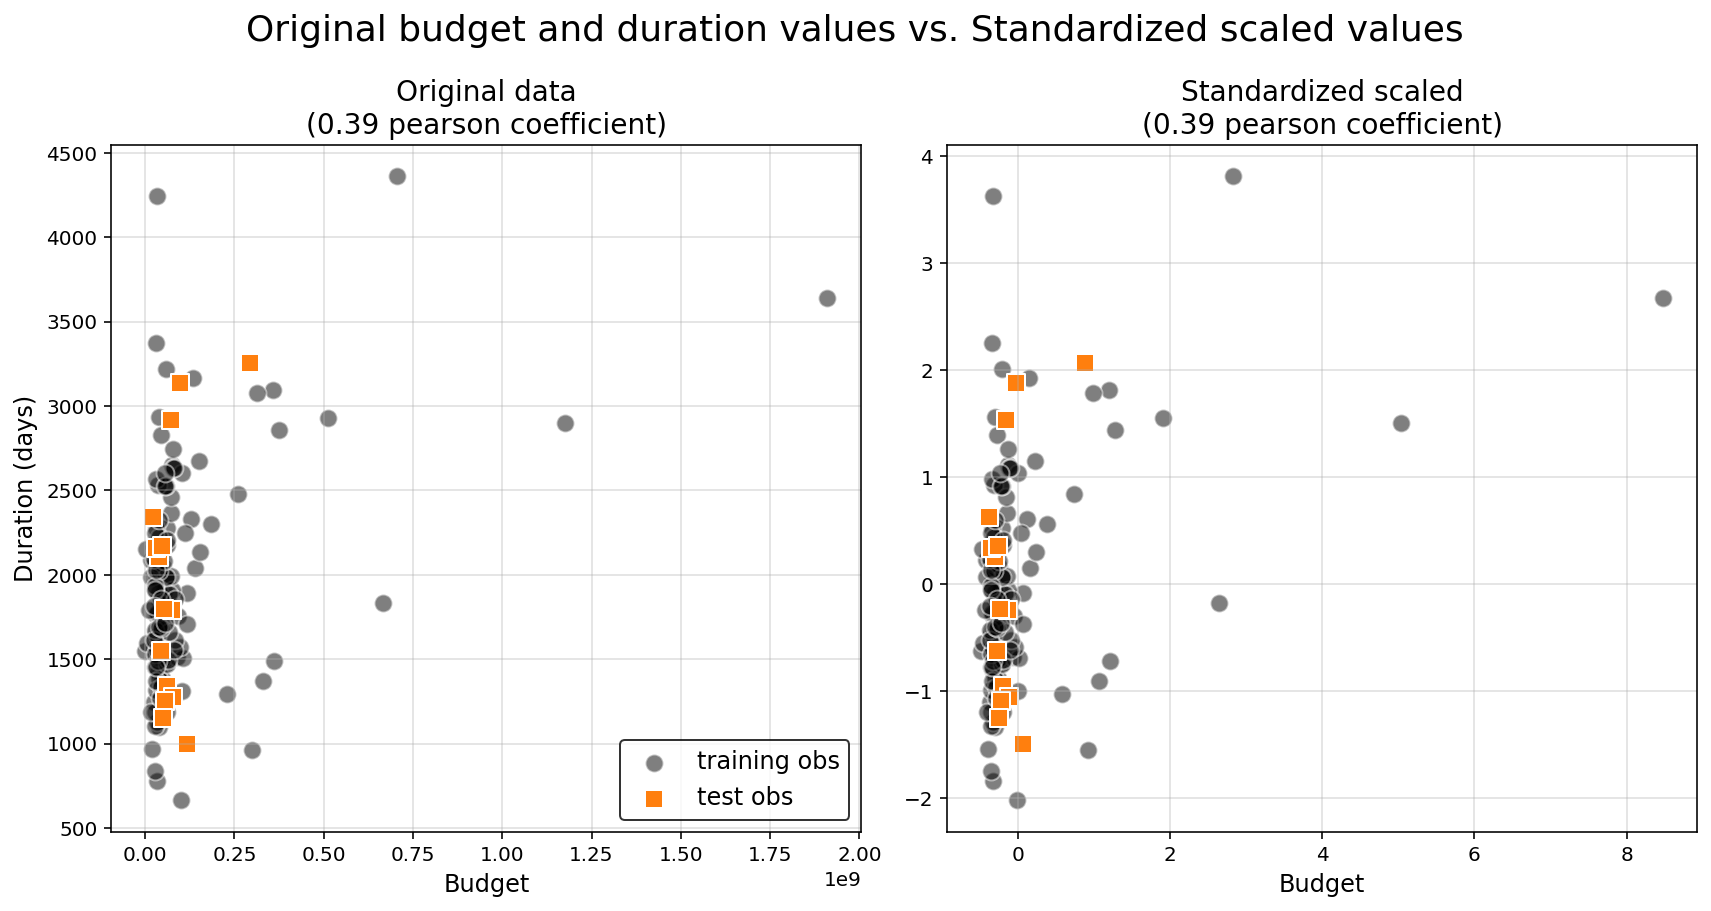

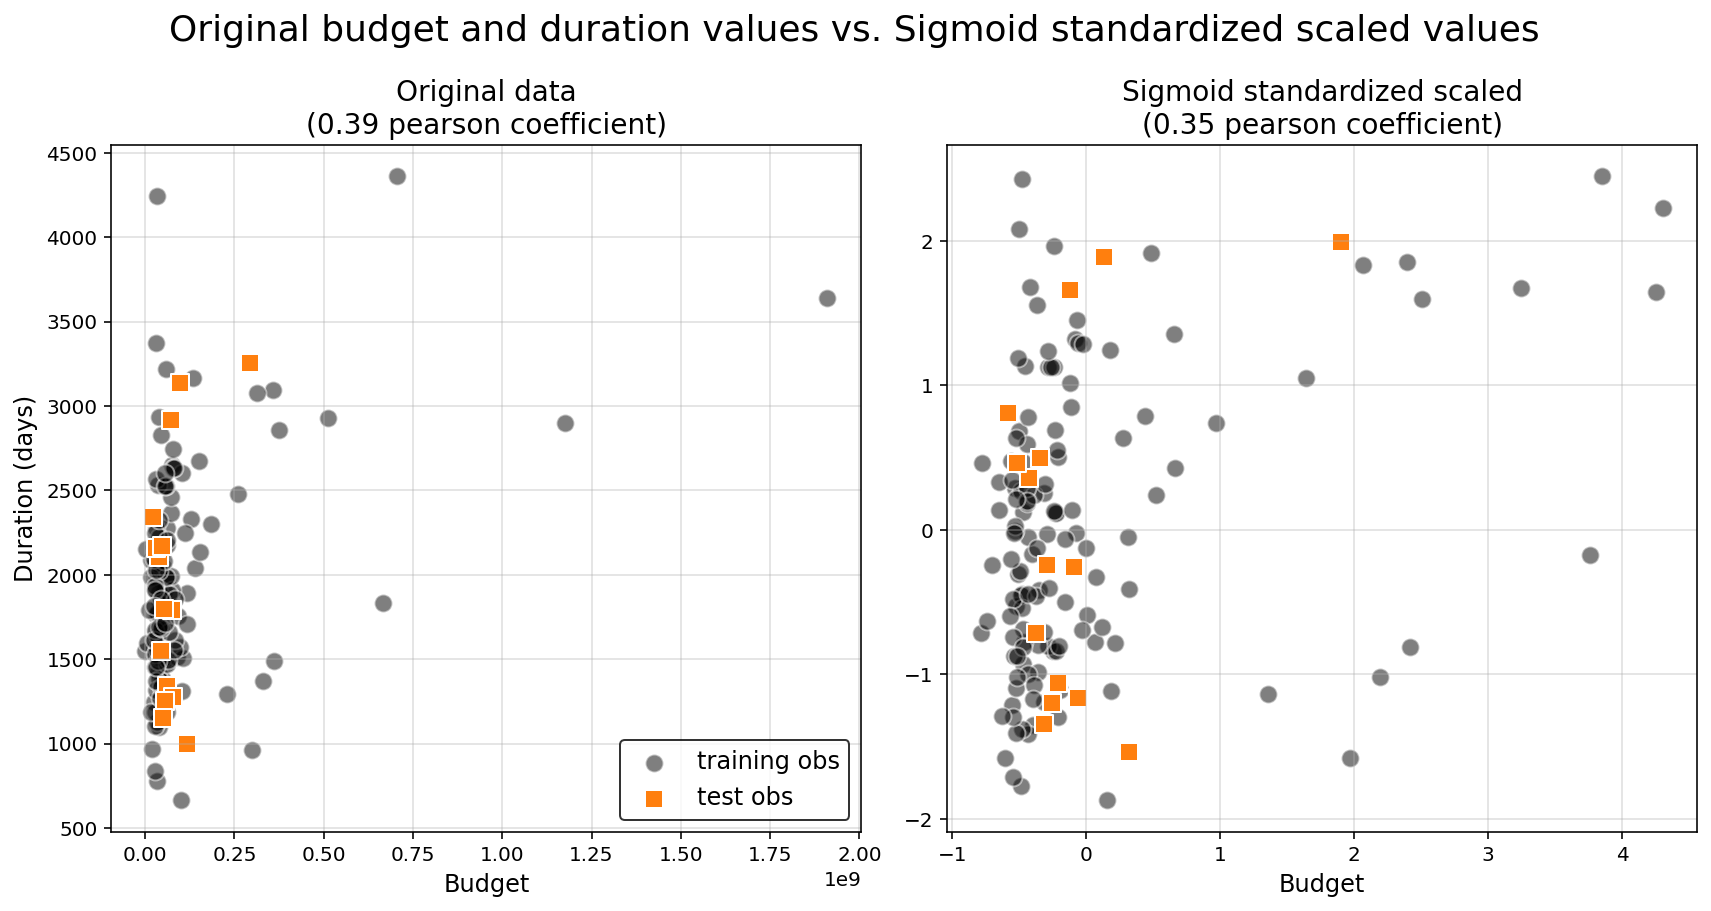

In [28]:
# inspect scaled datasets
plot_bdgt_sched_scaled(X_train, X_train_std, 'Standardized', X_test, X_test_std)
plot_bdgt_sched_scaled(X_train, X_train_std_sig, 'Sigmoid standardized', X_test, X_test_std_sig)

**FINDINGS**:

By visualizing our `Budget_Start` and `Duration_Start` predictors above, we can see a large skew with clear outliers in the original unscaled data. By applying standardization to the these predictors, as we have illustrated in the upper righthand plot, we have set both variables to the same scale. However, standardizing has not alleviated the skewness of our data or helped with our outlying datapoints. 

Therefore, we have also applied a sigmoid transformation to the data and re-standardized, as is shown in the lower righthand plot. This sigmoid transformation has helped to alleviate the skew of our data, and it has also helped to more evenly distrubute all of our data points, drawing outliers far closer to the center of the distribution.

**Now we will fit a "Baseline" linear regression model on our scaled datasets to see which performs best.**

<a name='baseline'></a>

## 4.1 Baseline Linear Regression

<a href=#linear>Return to section index</a>

**The unabridged notebook used to generate the findings in this section can be [found here on GitHub.](https://github.com/mcdomx/cs109b_groupproject/blob/master/notebooks/05_baseline_linear_models.ipynb)**

### Fit "Baseline" linear regression model using only `Budget_Start` and `Duration_Start` predictors

In [29]:
features = [Conclusions
    'Budget_Start',
    'Duration_Start'
]

print(
    '\nThese 2 "BASELINE" models used the following predictors:\n\n\t{}\n\n'\
    ''.format(features)
)


sm_formulas = [
    ' + '.join(features),
    ' + '.join(features)
]

model_descr = 'Baseline linear regression, standardized data, 2 predictors'

model_LR2 = generate_model_dict(
    sm.ols,
    model_descr,
    X_train_std[features], X_test_std[features], y_train, y_test,
    multioutput=True,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='statsmodels',
    sm_formulas=sm_formulas,
)

print_model_results(model_LR2)

model_descr = 'Baseline linear regression, sigmoid standarized data, 2 predictors'

model_LR2_sig = generate_model_dict(
    sm.ols,
    model_descr,
    X_train_std_sig[features], X_test_std_sig[features], y_train, y_test,
    multioutput=True,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='statsmodels',
    sm_formulas=sm_formulas,
)


print_model_results(model_LR2_sig)


These 2 "BASELINE" models used the following predictors:

	['Budget_Start', 'Duration_Start']



MODEL SUMMARY:
Baseline linear regression, standardized data, 2 predictors


The fitted model object(s):




The formula for each fitted model object:

	Budget_Change_Ratio ~ Budget_Start + Duration_Start

	Schedule_Change_Ratio ~ Budget_Start + Duration_Start


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.0046
		Test		-0.4248

	Schedule_Change_Ratio

		Training	0.2260
		Test		0.2391




MODEL SUMMARY:
Baseline linear regression, sigmoid standarized data, 2 predictors


The fitted model object(s):




The formula for each fitted model object:

	Budget_Change_Ratio ~ Budget_Start + Duration_Start

	Schedule_Change_Ratio ~ Budget_Start + Duration_Start


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.0116
		Test		-0.3509

	Schedule_Change_Ratio

		Training	0.2332
		Test		0.2697





**FINDINGS:**

By using sigmoid scaled data for both our `Budget_Start` and `Schedule_Start` predictors, we can see that by reducing skew in our predictors, we have generated slightly better performance in predicting both `Budget_Change_Ratio` and `Schedule_Change_Ratio` in both our train and test sets.

While these are just true Baseline models in which we use Linear Regression with only 2 predictors, the results indicate that:

1. we may benefit from the use of sigmoid scaled data for those two baseline predictors


2. `Budget_Change_Ratio` may prove more difficult to predict than `Schedule_Change_Ratio`, wherein our predictions for `Budget_Change_Ratio` perform less well than a naive model as is indicated by the negative $R^2$ score for the test data.

### Fit "Baseline+" regression model, incorporating project `Category` as a predictor

In [30]:
features = list(X_train)[:-10]

print(
    '\nThis "BASELINE+" model uses the project Category '\
    'as one-hot-encoded predictors:'\
    '\n\n\t{}\n\n'.format(features)
)


sm_formulas = [
    ' + '.join(features),
    ' + '.join(features)
]

model_descr = 'Baseline linear regression, sigmoid standarized data, with categories'

model_LR3 = generate_model_dict(
    sm.ols,
    model_descr,
    X_train_std_sig[features], X_test_std_sig[features], y_train, y_test,
    multioutput=True,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='statsmodels',
    sm_formulas=sm_formulas,
)


print_model_results(model_LR3)


This "BASELINE+" model uses the project Category as one-hot-encoded predictors:

	['Budget_Start', 'Duration_Start', 'Bridges', 'Ferries', 'Industrial_Development', 'Parks', 'Sanitation', 'Schools', 'Sewers', 'Streets_and_Roadways', 'Wastewater_Treatment', 'Water_Supply', 'Category_Code']



MODEL SUMMARY:
Baseline linear regression, sigmoid standarized data, with categories


The fitted model object(s):




The formula for each fitted model object:

	Budget_Change_Ratio ~ Budget_Start + Duration_Start + Bridges + Ferries + Industrial_Development + Parks + Sanitation + Schools + Sewers + Streets_and_Roadways + Wastewater_Treatment + Water_Supply + Category_Code

	Schedule_Change_Ratio ~ Budget_Start + Duration_Start + Bridges + Ferries + Industrial_Development + Parks + Sanitation + Schools + Sewers + Streets_and_Roadways + Wastewater_Treatment + Water_Supply + Category_Code


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.0686
		Test		-2.53

**FINDINGS:**

By adding the one-hot-encoded `Category` feature to our model, which provides information about the type of project for each observation, we can see a clear improvement in our `Schedule_Change_Ratio` $R^2$ scores for both train and test predictions. 

Our `Budget_Change_Ratio` results on the otherhand have degraded in performance when compared to our simpler **Baseline** model with just 2 predictors. Regardless, neither the **Baseline** nor **Baseline+** linear regression models are able to predict 3-year `Budget_Change_Ratio` results better than the naive model, as is indicated by these $R^2$ results.

This indicates to us that we will likely have more difficulty in predicting `Budget_Change_Ratio` in our future models and that a Linear Regression model likely lacks the expressiveness required to adequately fit a model to the underlying relationship between predictors and outcome variable.

As on last step before moving on from Linear Regression, we will quickly inspect the predictions made by our **Baseline+** model, as well as the regression coefficients.


## Visualize Baseline+ predictions and coefficients

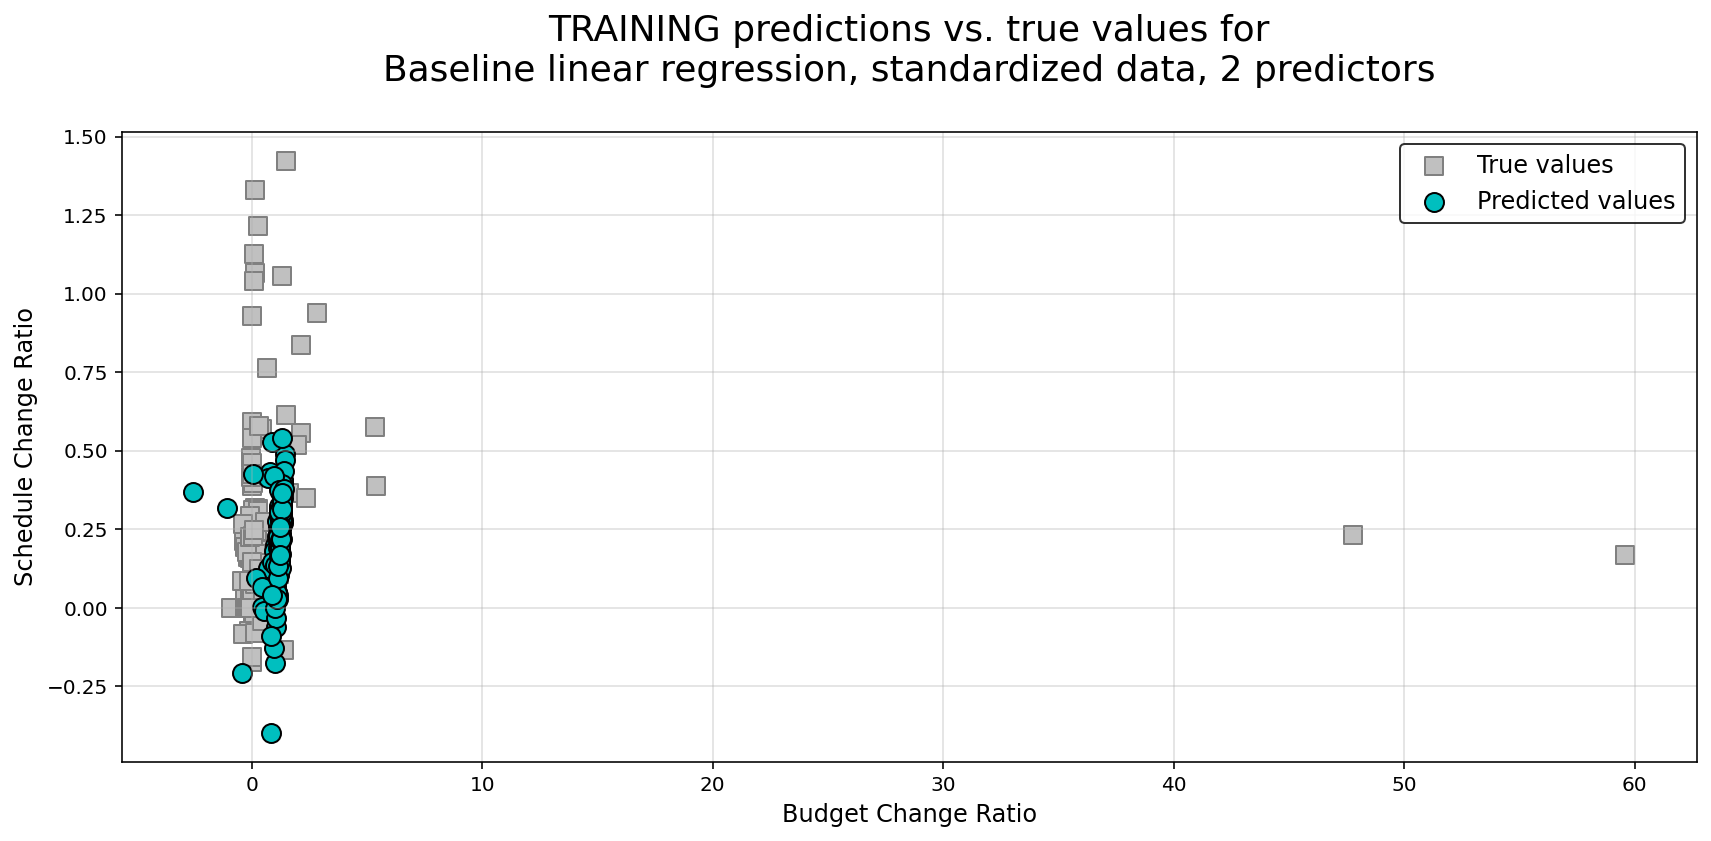

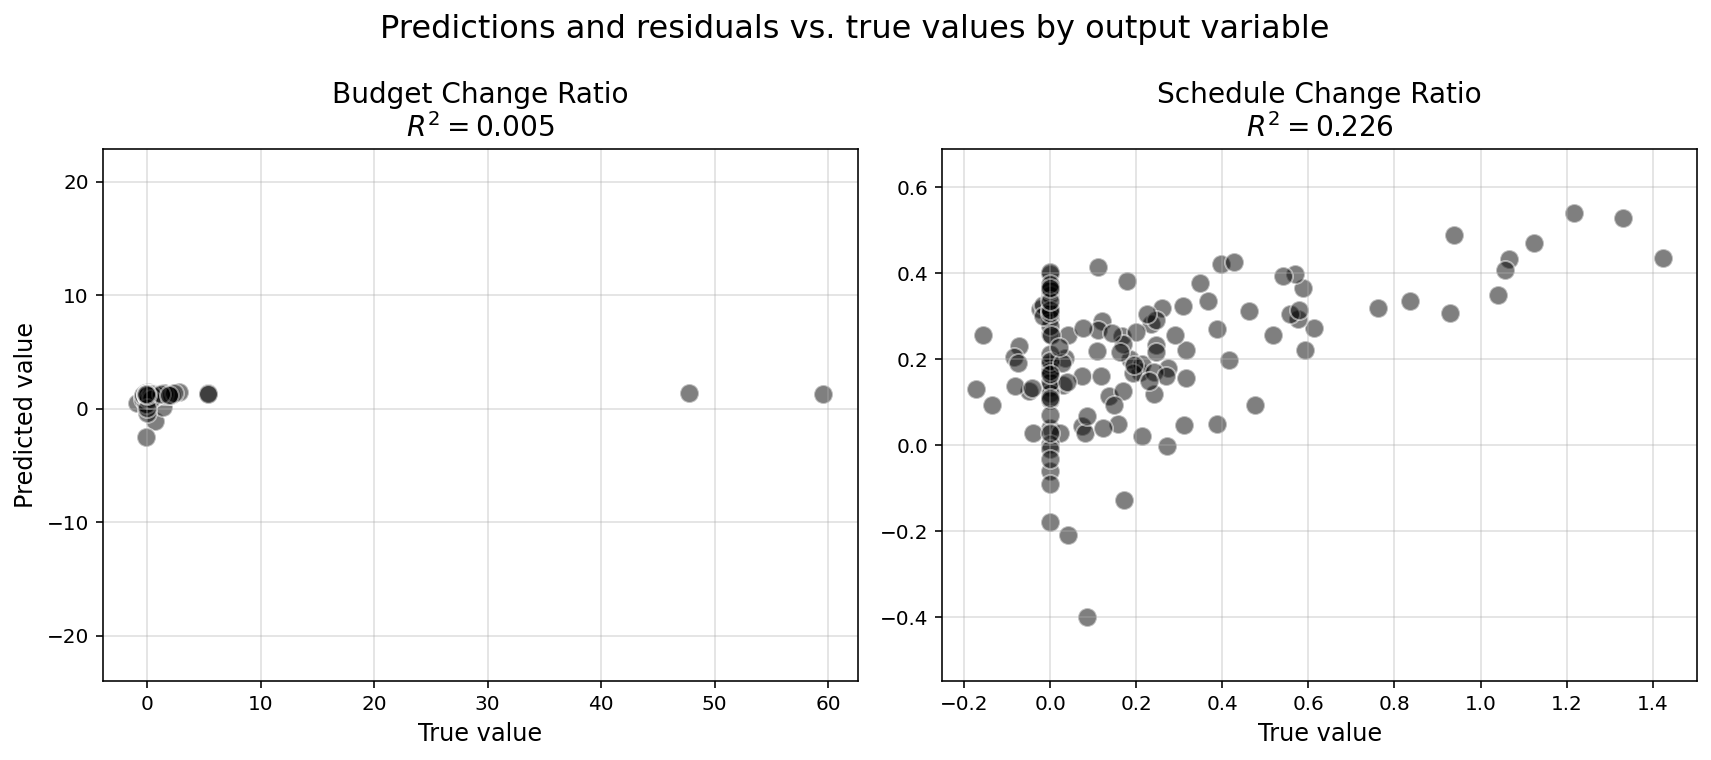

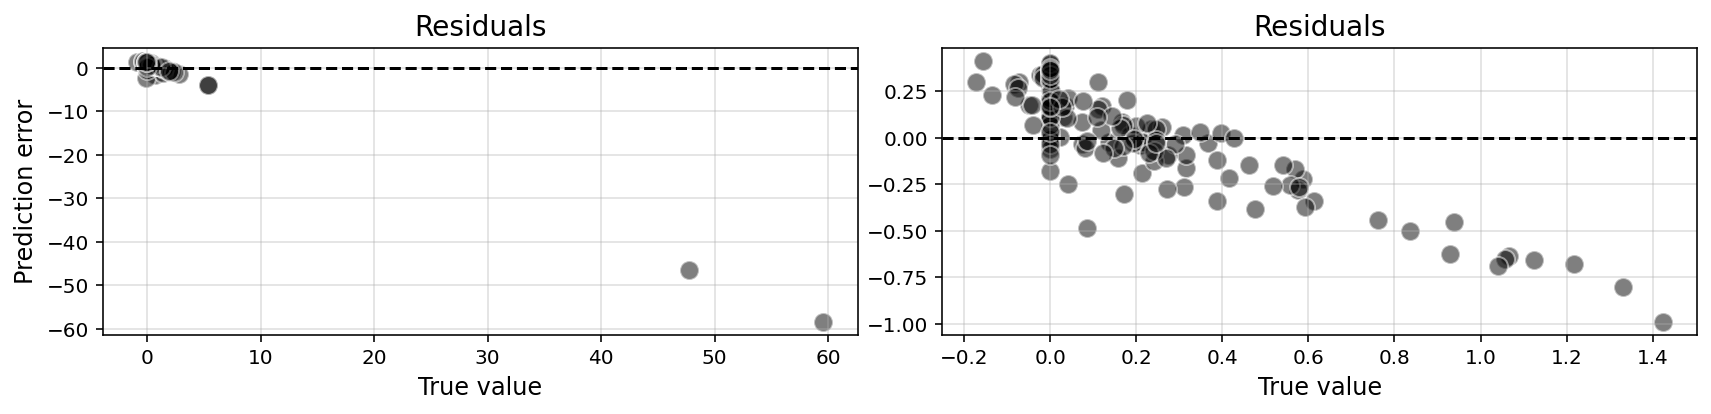

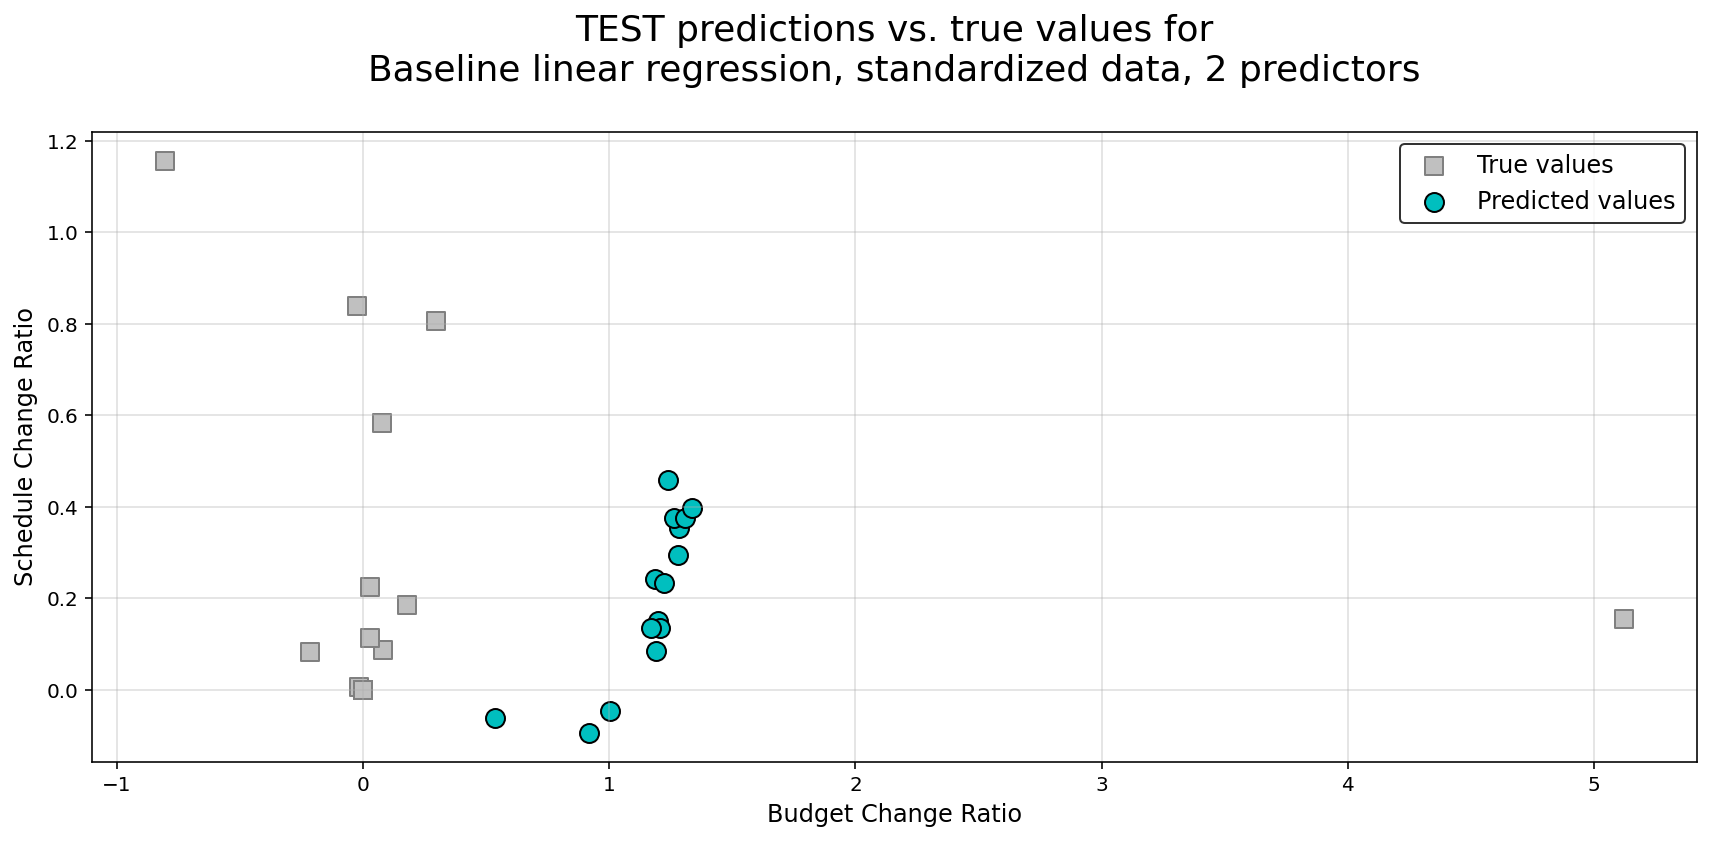

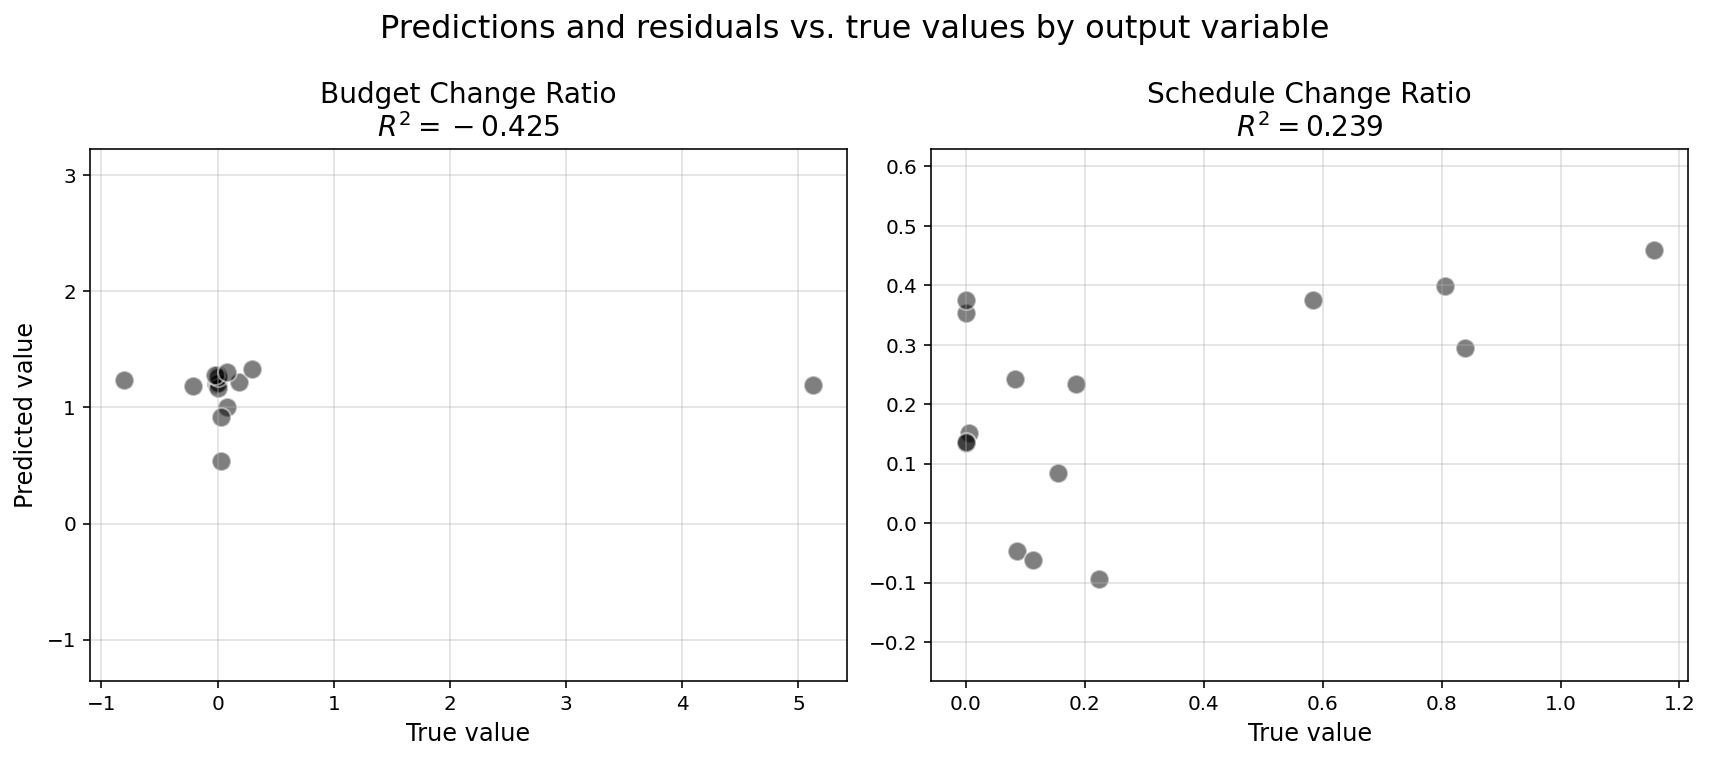

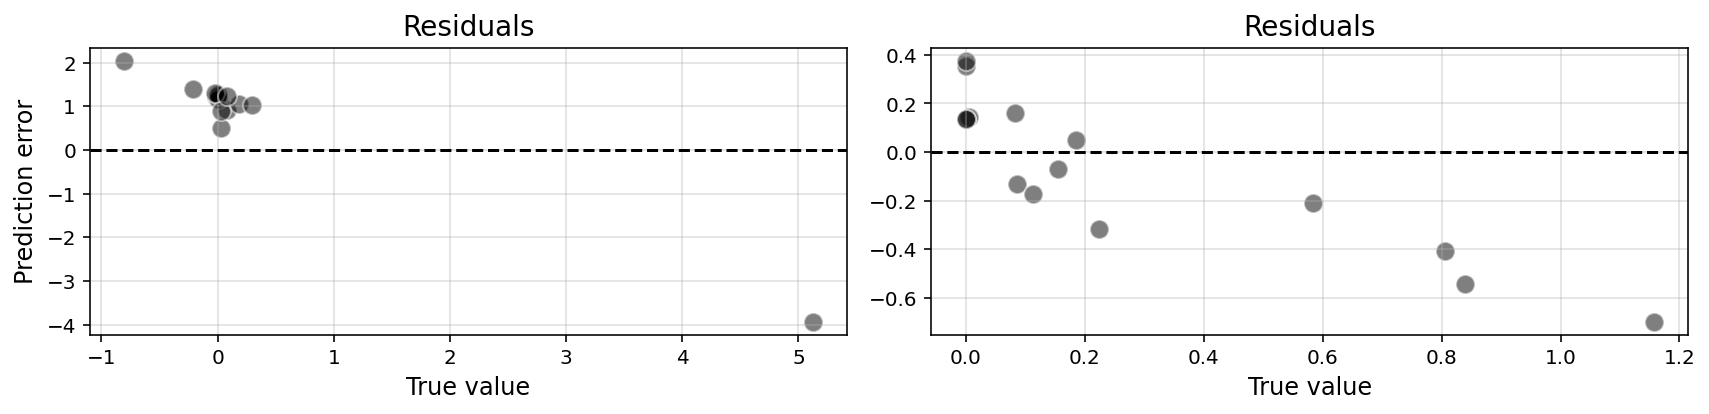

In [31]:
plot_true_pred(model_dict=model_LR2, dataset='train')
plot_true_pred(model_dict=model_LR2, dataset='test')

**ADD PLOT OF COEFFICIENTS & INTERPRETATION**

<a name='splines'></a>

## 4.2 Smoothing Spline Generalized Additive Models (GAMs)

<a href=#linear>Return to section index</a>

**IN THIS SECTION:**

**4.2.1. <a href=#spline1>Smoothing Spline GAMs with Baseline Predictors</a>**

**4.2.2. <a href=#spline2>Smoothing Spline GAMs with Engineered Features</a>**

<a name='spline1'></a>

## 4.2.1. Smoothing Spline GAMs with Baseline Predictors

<a href=#splines>Return to section index</a>

**The unabridged notebook used to generate the findings in this section can be [found here on GitHub.](https://github.com/mcdomx/cs109b_groupproject/blob/master/notebooks/06_smoothing_spline_models.ipynb)**

In [32]:
Conclusionsfeatures = [
    'Budget_Start',
    'Duration_Start',
    'Category_Code',
]

print(
    '\nThis smoothing spline GAM uses the same predictors as our '\
    '"BASELINE+" regression model,\nexcept Category is label-encoded '\
    'instead of one-hot-encoded:'\
    '\n\n\t{}\n\n'.format(features)
)


model_descr = 'Smoothing spline GAM, sigmoid standarized data, with categories'

terms = s(0) + s(1) + f(2)

model_GAM0 = generate_model_dict(
    LinearGAM,
    model_descr,
    X_train_std_sig[features], X_test_std_sig[features], y_train, y_test,
    multioutput=False,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='sklearn',
    terms=terms,
)


print_model_results(model_GAM0)


This smoothing spline GAM uses the same predictors as our "BASELINE+" regression model,
except Category is label-encoded instead of one-hot-encoded:

	['Budget_Start', 'Duration_Start', 'Category_Code']



MODEL SUMMARY:
Smoothing spline GAM, sigmoid standarized data, with categories


The fitted model object(s):

	LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

	LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.5426
		Test		-1.1546

	Schedule_Change_Ratio

		Training	0.6628
		Test		0.5840





**FINDINGS:**

Here we can see that we stand to benefit from the added expressiveness of a smoothing spline class of linear model, as is illustrated by the improved $R^2$ results shown above. However, while our `Schedule_Change_Ratio` predictions have improved from $R^2=0.34$ to $R^2=0.58$, our `Budget_Change_Ratio` test $R^2$ score is still extremely negative. However, the smoothing spline GAM does appear to have fitted the training set with a `Budget_Change_Ratio` $R^2$ score of 0.54, which is somewhat promising. Now, if only we can improve on this to find a model that generalizes when to unseen data.

### Use gridsearch to find optimal value $\lambda$ for each term in the smoothing spline GAM model

- Here we treat each y output independently, partly because PyGam's Linear GAM will not fit a multi-output model, but mostly because each y output behaves differently and we have found that different $\lambda$ values are required to optimize both output


- We also use PyGam's native `gridsearch` method to choose our values $\lambda$.
    - Because there are so few instances of some project categories, traditional cross-validation using k-splits creates instances where some train instances are missing one or two categories
    - When that occurs, PyGam cannot fit a coefficient to that category and generates an error.
    

In [33]:
terms = s(0) + s(1) + f(2)

# generate list of lambdas against which to perform gridsearch for
# each outcome variable and each of our 3 input predictors
lam_list = np.logspace(-3, 5, 10)
lams = [lam_list] * 3

# fit GAM to predict budget change ratio 
gam1 = LinearGAM(terms).fit(
    X_train_std_sig[features], y_train['Budget_Change_Ratio']
)
# perform gridsearch to find optimal lambdas for each term
gam1.gridsearch(
    X_train_std_sig[features], y_train['Budget_Change_Ratio'],
    lam=lams
)

# fit GAM to predict schedule change ratio
gam2 = LinearGAM(terms).fit(
    X_train_std_sig[features], y_train['Schedule_Change_Ratio']
)
# perform gridsearch to find optimal lambdas for each term
gam2.gridsearch(
    X_train_std_sig[features], y_train['Schedule_Change_Ratio'],
    lam=lams
)

100% (1000 of 1000) |####################| Elapsed Time: 0:00:19 Time:  0:00:19
100% (1000 of 1000) |####################| Elapsed Time: 0:00:19 Time:  0:00:19


LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

In [18]:
%%capture --no-stdout

print(
    '\nGAM gridsearch results for BUDGET_CHANGE_RATIO prediction model:\n'
)
gam1.summary()

print(
    '\n\n\nGAM gridsearch results for SCHEDULE_CHANGE_RATIO prediction model:\n'
)
gam2.summary()


GAM gridsearch results for BUDGET_CHANGE_RATIO prediction model:

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     18.7569
Link Function:                     IdentityLink Log Likelihood:                                  -419.7587
Number of Samples:                          134 AIC:                                              879.0312
                                                AICc:                                             886.2739
                                                GCV:                                               11.5842
                                                Scale:                                              8.7077
                                                Pseudo R-Squared:            

**ADD INTERPRETATION**

In [19]:
print(
    '\nThese smoothing spline GAMs have been fit using the optimal lambda penalties '\
    'for each term, one set of results show models optimized for BUDGET_CHANGE_RATIO '\
    'predictions, the other for SCHEDULE_CHANGE_RATIO predictions.\n\n'\
    'The predictors used are:\n\n\t{}\n\n'.format(features)
)


model_descr = 'Smoothing spline GAM: sigmoid scaled, BUDGET_CHANGE_RATIO optimal penalties'

terms = s(0, lam=0.001) + s(1, lam=100000) + f(2, lam=215.4435)

model_GAM1 = generate_model_dict(
    LinearGAM,
    model_descr,
    X_train_std_sig[features], X_test_std_sig[features], y_train, y_test,
    multioutput=False,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='sklearn',
    terms=terms,
)

print_model_results(model_GAM1)

model_descr = 'Smoothing spline GAM: sigmoid scaled, SCHEDULE_CHANGE_RATIO optimal penalties'

terms = s(0, lam=100000) + s(1, lam=27.8256) + f(2, lam=3.5938)

model_GAM2 = generate_model_dict(
    LinearGAM,
    model_descr,
    X_train_std_sig[features], X_test_std_sig[features], y_train, y_test,
    multioutput=False,
    verbose=False,
    predictions=True,
    scores=True,
    model_api='sklearn',
    terms=terms,
)


# generate_model_dict(
#     LinearGAM, model_descr, X_le_tr_std_sig, X_le_te_std_sig, y_train, y_test, terms=terms, multioutput=False
# )

print_model_results(model_GAM2)


These smoothing spline GAMs have been fit using the optimal lambda penalties for each term, one set of results show models optimized for BUDGET_CHANGE_RATIO predictions, the other for SCHEDULE_CHANGE_RATIO predictions.

The predictors used are:

	['Budget_Start', 'Duration_Start', 'Category_Code']



MODEL SUMMARY:
Smoothing spline GAM: sigmoid scaled, BUDGET_CHANGE_RATIO optimal penalties


The fitted model object(s):

	LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)

	LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + s(1) + f(2) + intercept, 
   tol=0.0001, verbose=False)


This model resulted in the following R-squared scores:

	Budget_Change_Ratio

		Training	0.8263
		Test		-0.8736

	Schedule_Change_Ratio

		Training	0.3532
		Test		0.0337




MODEL SUMMARY:
Smoothing spline GAM: sigmoid scaled, SCHEDULE_CHANGE_RAT

**ADD INTERPRETATION**

### Visualize optimized baseline smoothing spline GAM predictions and contribution by predictor

In [20]:
y_pred_train = np.hstack(
    [
        model_GAM1['predictions']['train'][:, 0].reshape(-1,1),
        model_GAM2['predictions']['train'][:, 1].reshape(-1,1)
    ]
)

y_pred_test = np.hstack(
    [
        model_GAM1['predictions']['test'][:, 0].reshape(-1,1),
        model_GAM2['predictions']['test'][:, 1].reshape(-1,1)
    ]
)

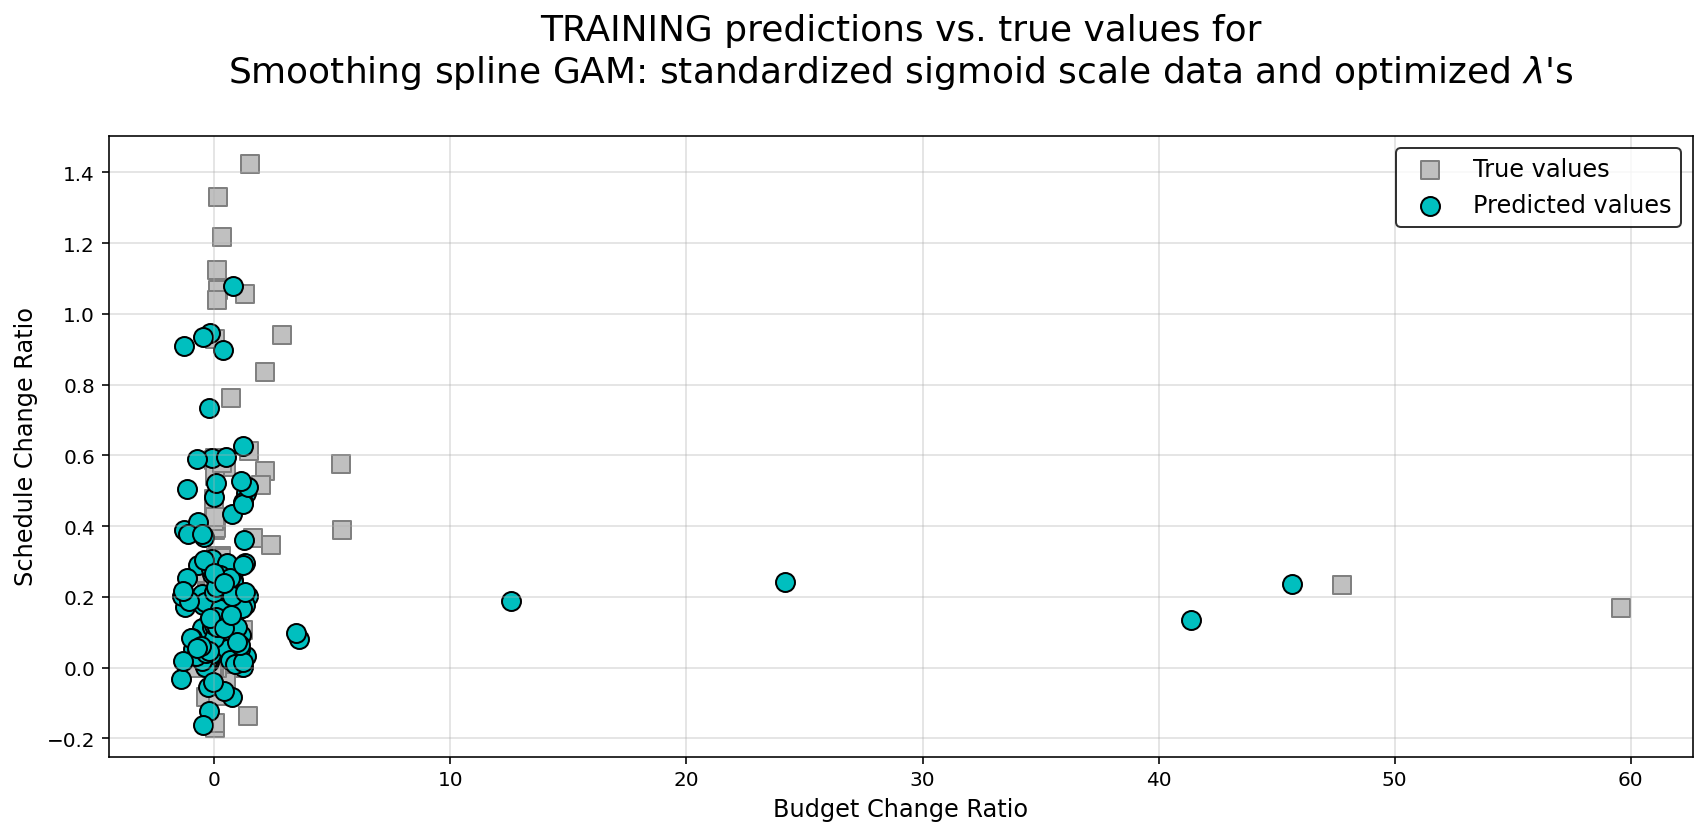

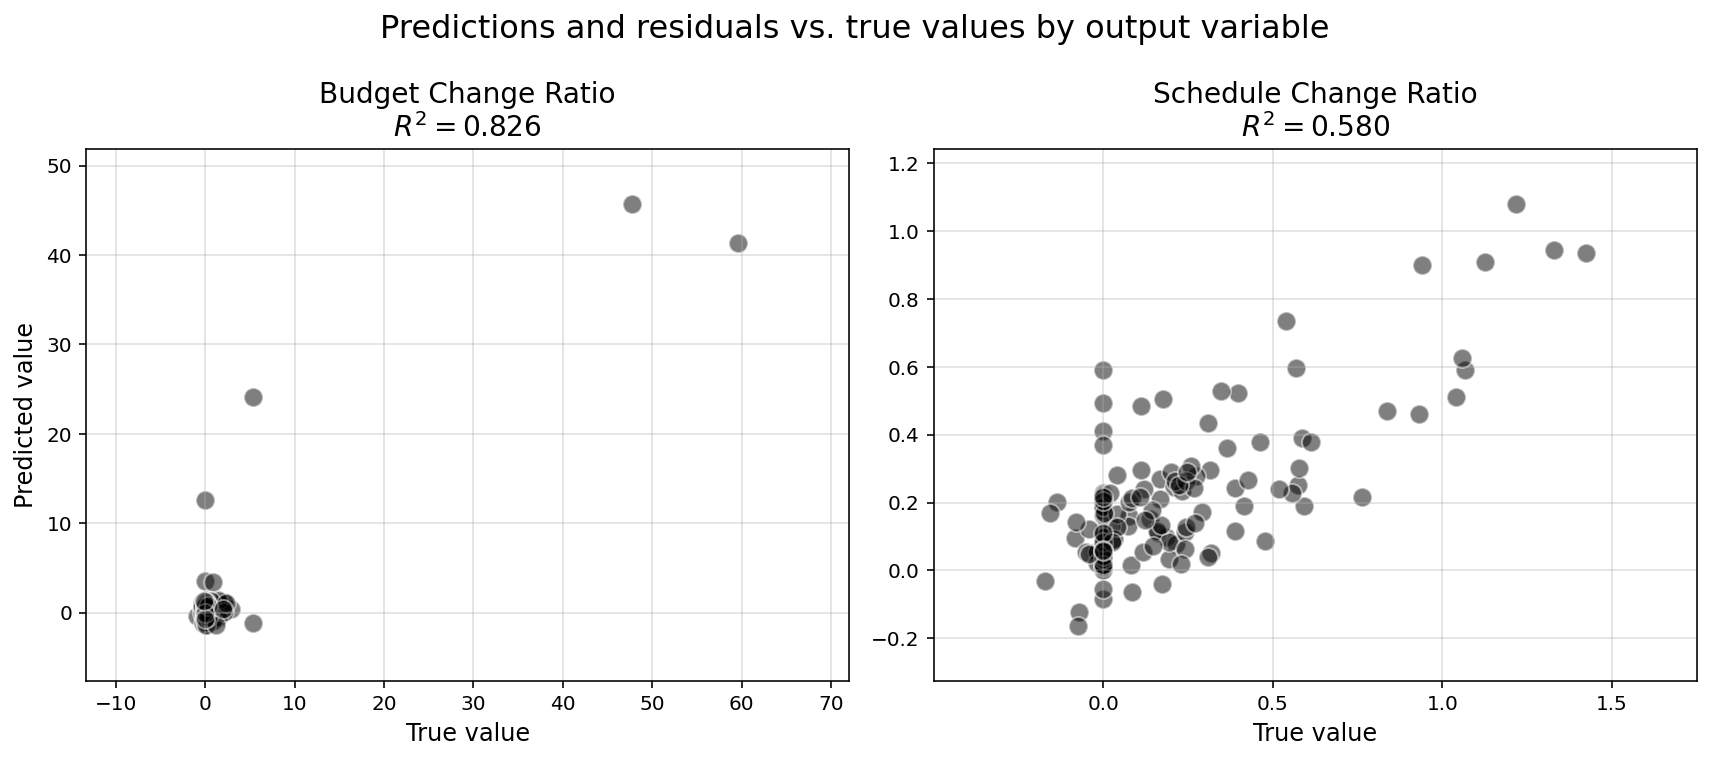

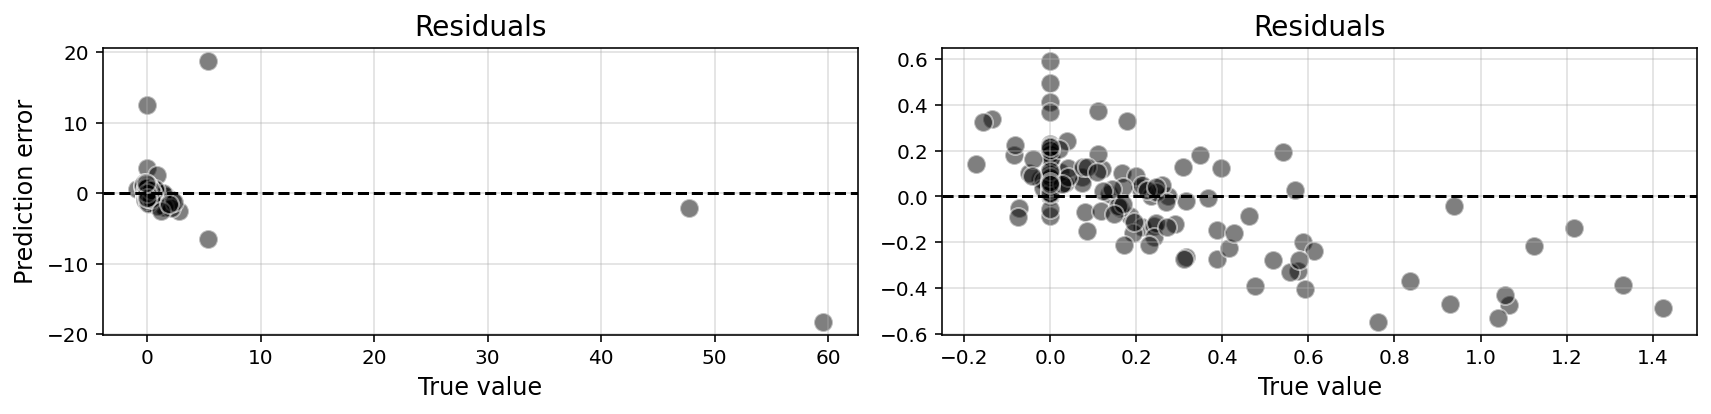

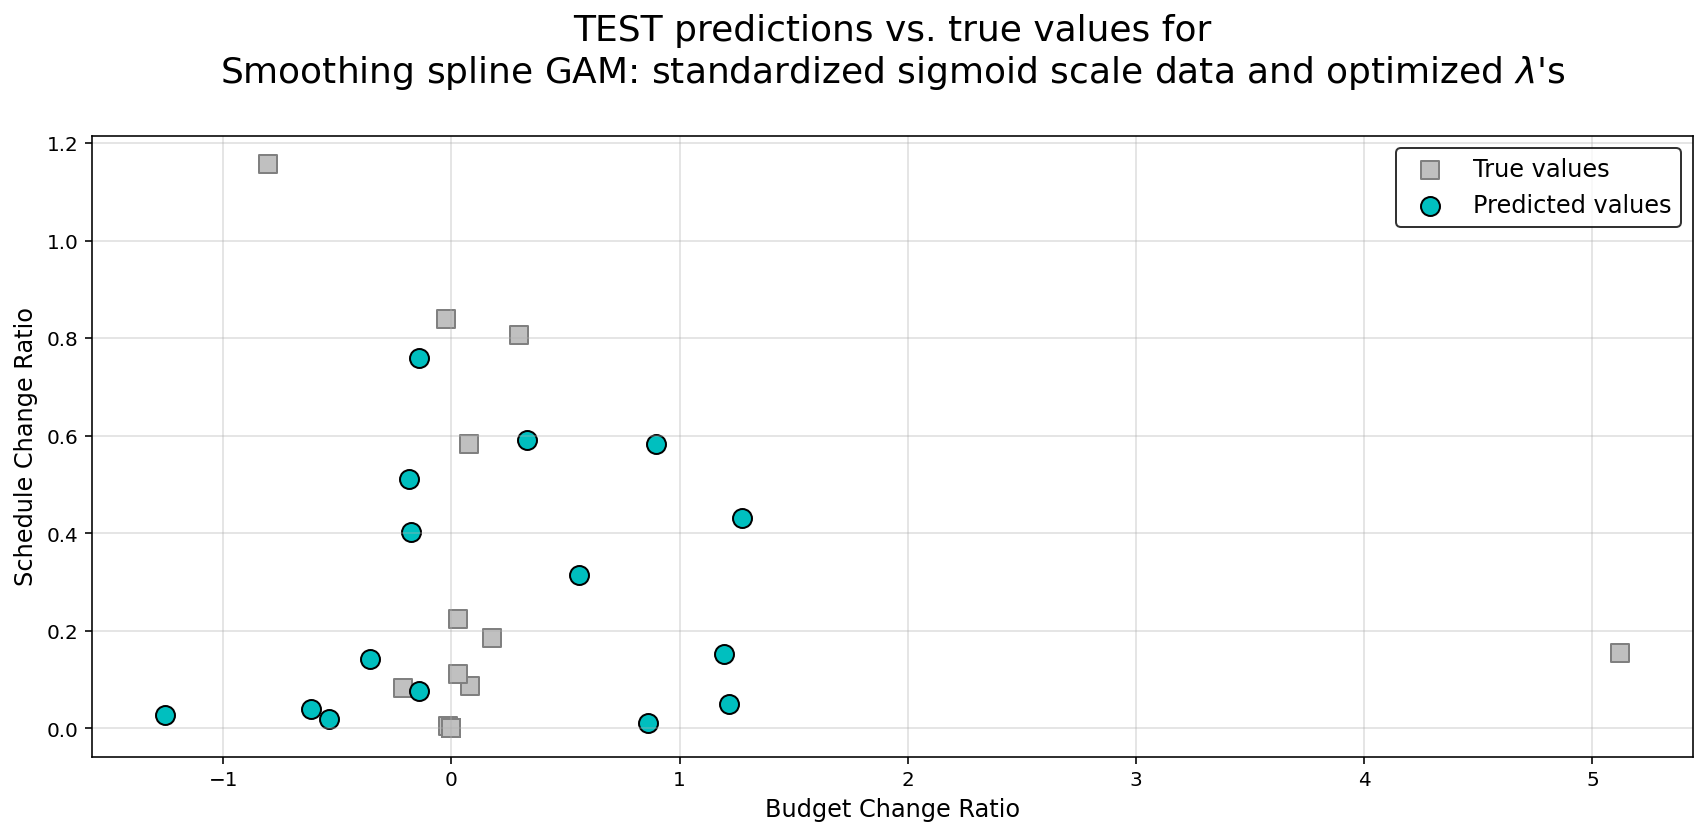

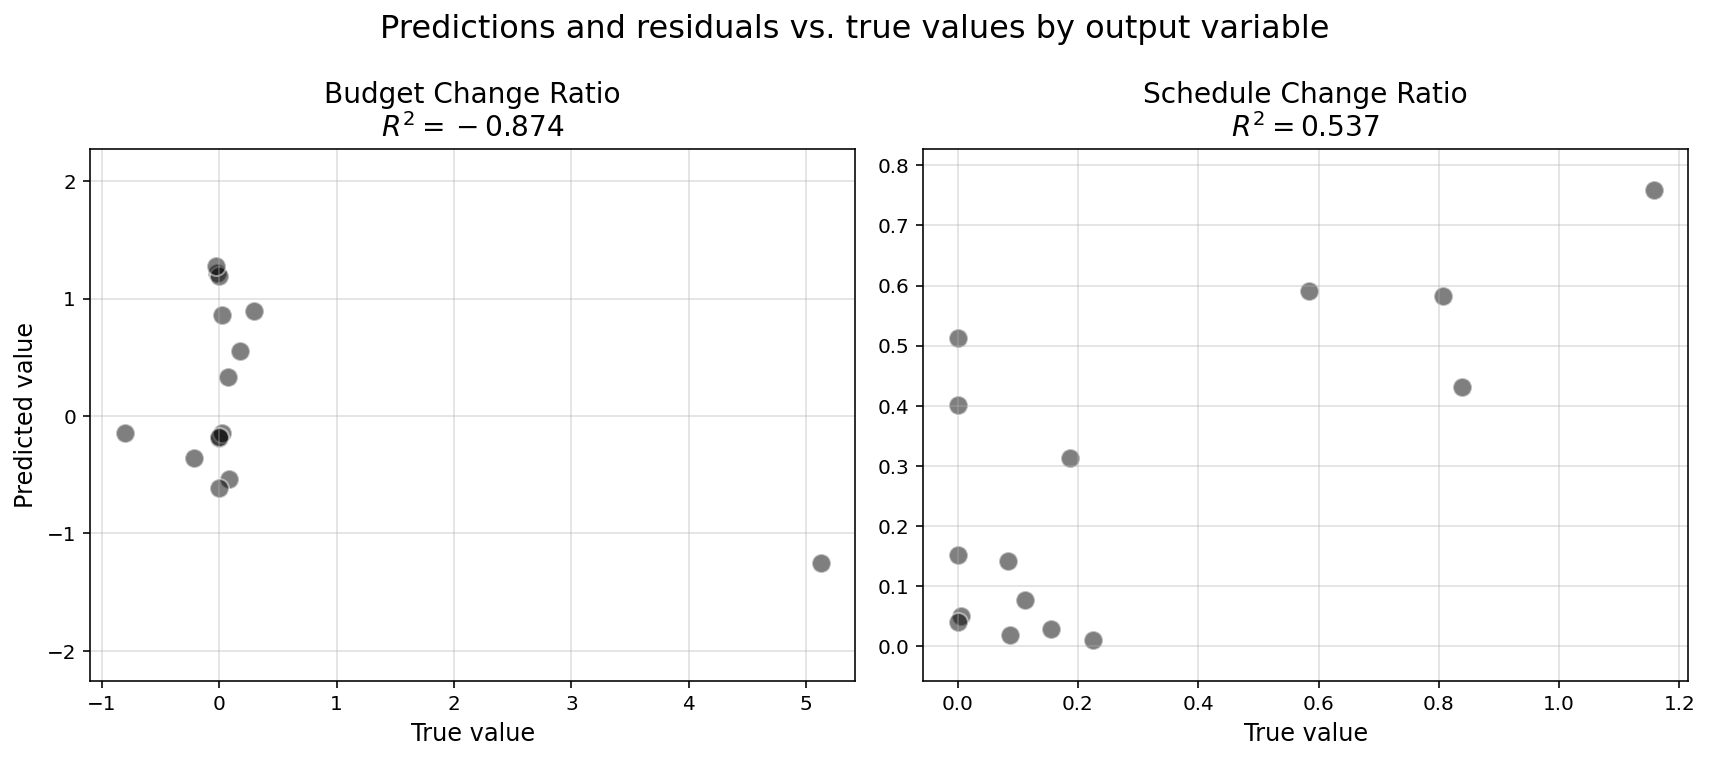

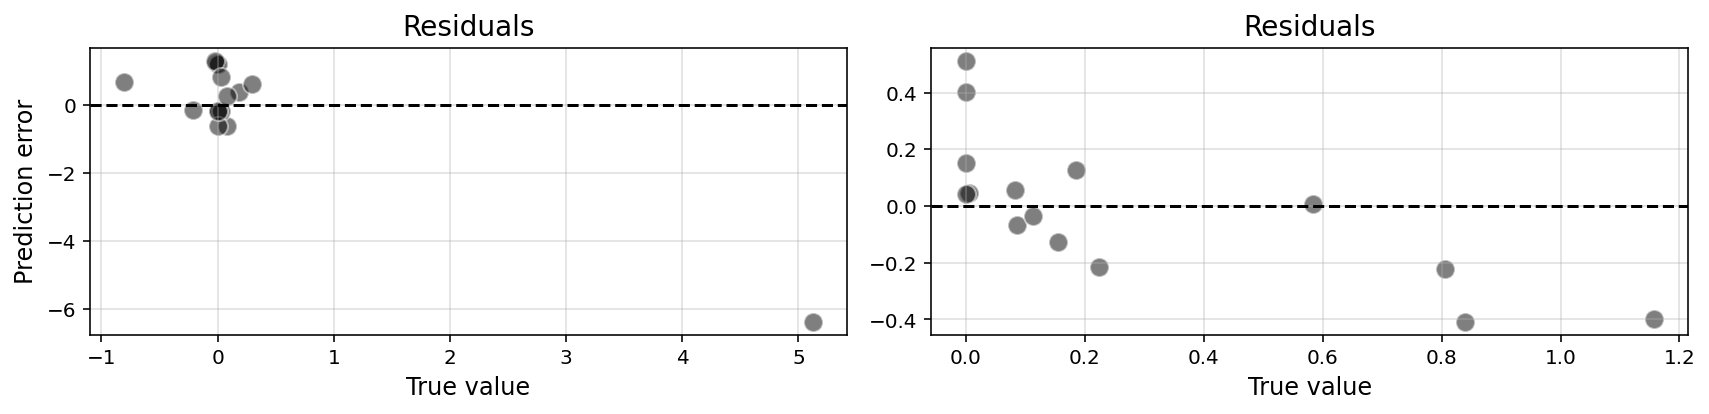

In [21]:
Conclusionsmodel_descr = "Smoothing spline GAM: standardized sigmoid scale data and optimized $\lambda$'s"
y1_label = 'Budget Change Ratio'
y2_label = 'Schedule Change Ratio'

plot_true_pred(
    dataset='train',
    y_true=y_train,
    y_pred=y_pred_train,
    y1_label=y1_label,
    y2_label=y2_label,
    model_descr=model_descr
)
plot_true_pred(
    dataset='test',
    y_true=y_test,
    y_pred=y_pred_test,
    y1_label=y1_label,
    y2_label=y2_label,
    model_descr=model_descr
)

**ADD INTERPRETATION**

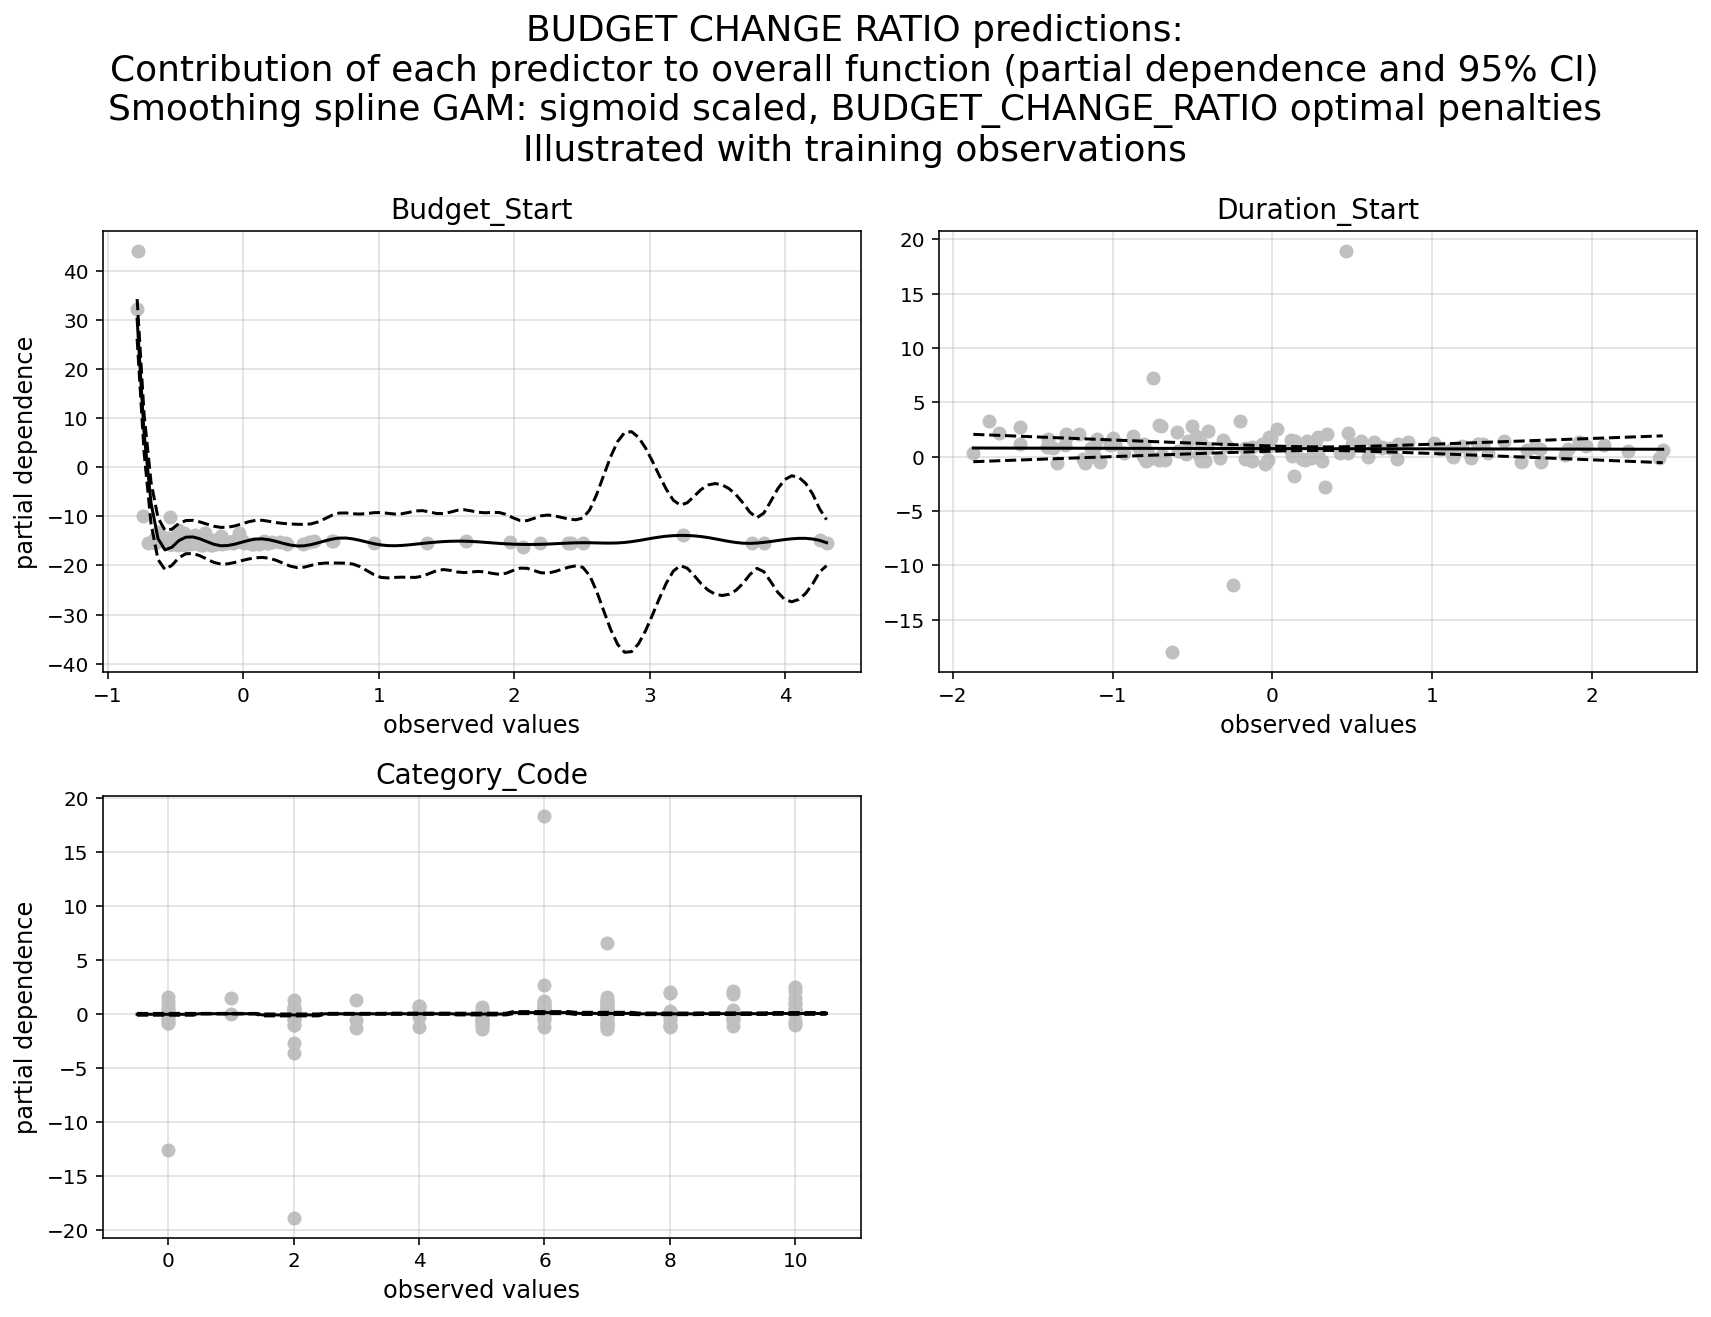

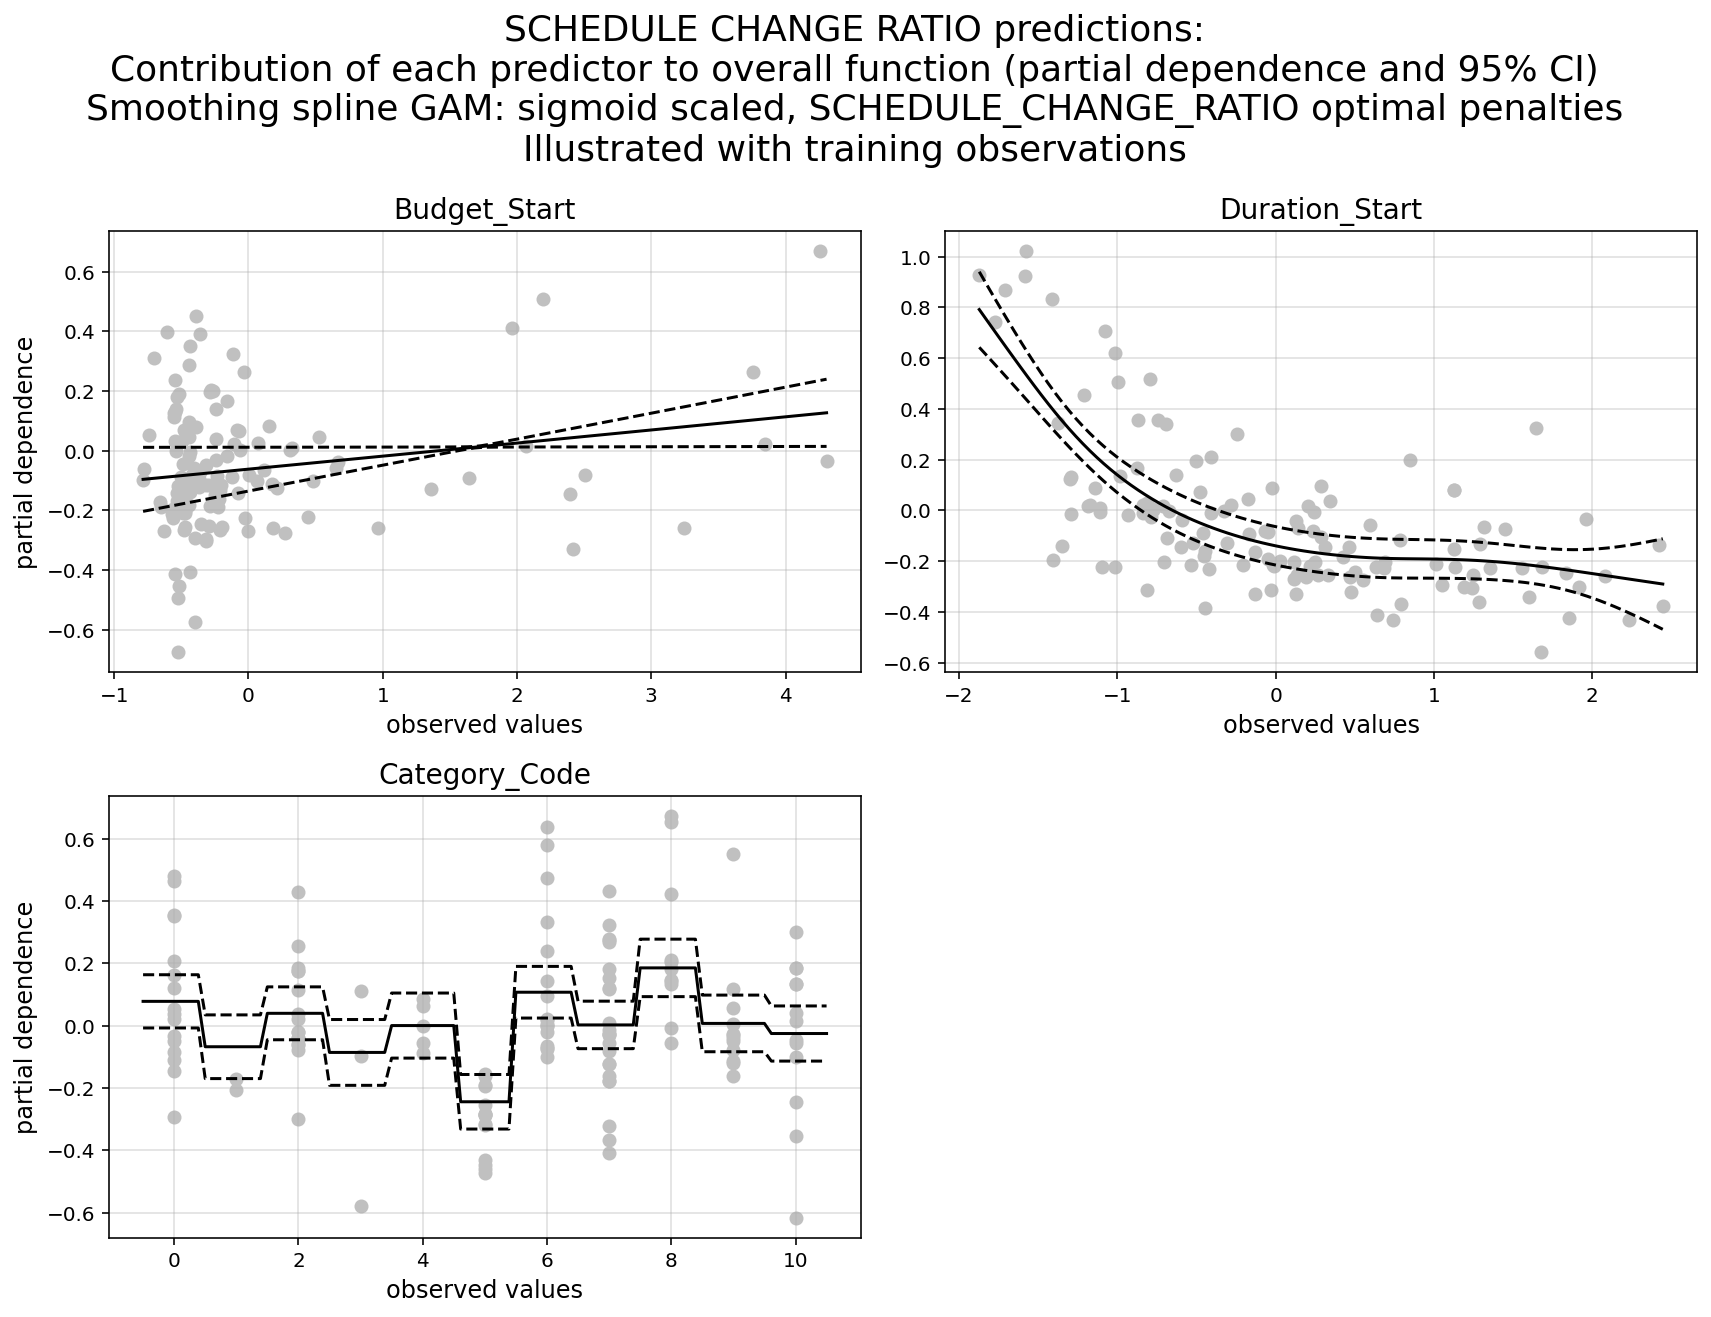

In [23]:
plot_gam_by_predictor(
    model_dict=model_GAM1, model_index=0,
    X_data=X_train_std_sig[features], y_data=y_train,
    dataset='train'
)

print()
plot_gam_by_predictor(
    model_dict=model_GAM2, model_index=1,
    X_data=X_train_std_sig[features], y_data=y_train,
    dataset='train'
)

**ADD INTERPRETATION & CONCLUSIONS**

<a name='spline2'></a>

## 4.2.2. Smoothing Spline GAMs with Engineered Features

<a href=#splines>Return to section index</a>

**The unabridged notebook used to generate the findings in this section can be [found here on GitHub.](https://github.com/mcdomx/cs109b_groupproject/blob/master/notebooks/06_smoothing_spline_models.ipynb)**

<a name='nonparam'></a>

# 5. Nonparametric Models 

<a href=#index>Index</a>

**IN THIS SECTION:**

**5.1. <a href=#trees>Decision tree regressors</a>**

**5.2. <a href=#boost>Ensemble tree regressors with boosting</a>**


<a name='trees'></a>

## 5.1. Decision Tree Regressors

<a href=#nonparam>Return to section index</a>

**The unabridged notebook used to generate the findings in this section can be [found here on GitHub.](https://github.com/mcdomx/cs109b_groupproject/blob/master/notebooks/07_decision_tree_models.ipynb)**

<a name='boost'></a>

## 5.2. Ensemble Tree Regressors with Boosting

<a href=#nonparam>Return to section index</a>

**The unabridged notebook used to generate the findings in this section can be [found here on GitHub.](https://github.com/mcdomx/cs109b_groupproject/blob/master/notebooks/08_ensemble_tree_models.ipynb)**

<a name='conclusions'></a>

# 6. Conclusions 

<a href=#index>Index</a>

<a name='future'></a>

# 7. Next steps & future work

<a href=#index>Index</a>

<a name='sources'></a>

# 8. Sources & References 

<a href=#index>Index</a>

<a name='appendix'></a>

# 9. Appendix 

<a href=#index>Index</a>

**IN THIS SECTION:**

**9.1. <a href=#dict>Dictionary of features in final dataset</a>**

<a name='dict'></a>

## 9.1. Data Dictionary of Features In Final Dataset

<a href=#appendix>Return to section index</a>

**The `.csv` file used to generate this data dictionary can be [found here on GitHub.](https://github.com/mcdomx/cs109b_groupproject/blob/master/references/data_dicts/data_dict_interval.csv)**